## Introduction

This notebook is to build the model for Intel's cervical type prediction competition on kaggle. We will be using convolutional neural networks for the prediction, using a pre-trained resnet50 model, and finetuning it for our data.

In [1]:
%pwd

u'/data0/krohitm/repo/fast_ai/deeplearning1/nbs'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/intel/data/cervical'

In [3]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

Using cuDNN version 5105 on context None
Mapped name None to device cuda: TITAN X (Pascal) (0000:03:00.0)
Using Theano backend.


## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

In [4]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical
mkdir: cannot create directory ‘results’: File exists


In [6]:
%cd $DATA_HOME_DIR/train

/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical/train


## Rearrange image files into their respective directories

In [7]:
_,dirs,_ = os.walk('./').next()
for dir in dirs:
    %cd ./$dir
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(int(.2*len(shuf))): 
        os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + dir + '.'+ shuf[i])
    %cd ..

/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical/train/Type_2
/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical/train
/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical/train/Type_1
/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical/train
/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical/train/Type_3
/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical/train


In [ ]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

In [4]:
%cd $current_dir

/data0/krohitm/repo/fast_ai/deeplearning1/nbs


In [24]:
print DATA_HOME_DIR

/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical


## Finetuning and Training

In [7]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR# + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/data0/krohitm/repo/fast_ai/deeplearning1/nbs/intel/data/cervical


In [33]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=32
no_of_epochs=1

In [34]:
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
from PIL import ImageFile
from keras.preprocessing import image
ImageFile.LOAD_TRUNCATED_IMAGES = True

gen=image.ImageDataGenerator(rescale = 1.0/255)
batches = gen.flow_from_directory(train_path, target_size=(224,224),
                        class_mode='categorical', shuffle=True, batch_size=batch_size)
val_batches = gen.flow_from_directory(valid_path, target_size=(224,224),
                        class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 6968 images belonging to 3 classes.
Found 1617 images belonging to 3 classes.


In [35]:
from keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [37]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

In [38]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- for the 3 classes
predictions = Dense(3, activation='softmax')(x)
# this is the model we will train
model = Model(input=base_model.input, output=predictions)

In [39]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Resnet50 layers
for layer in base_model.layers:
    layer.trainable = False

In [40]:
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
#model.load_weights(path+'/keras_intel_stg2_new.h5')

In [41]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=no_of_epochs,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
6968/6968 [==============================] - 2480s - loss: 1.0470 - acc: 0.4872 - val_loss: 1.2773 - val_acc: 0.5220

In [42]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from resnet. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

(0, 'input_3')
(1, 'zeropadding2d_3')
(2, 'conv1')
(3, 'bn_conv1')
(4, 'activation_99')
(5, 'maxpooling2d_3')
(6, 'res2a_branch2a')
(7, 'bn2a_branch2a')
(8, 'activation_100')
(9, 'res2a_branch2b')
(10, 'bn2a_branch2b')
(11, 'activation_101')
(12, 'res2a_branch2c')
(13, 'res2a_branch1')
(14, 'bn2a_branch2c')
(15, 'bn2a_branch1')
(16, 'merge_33')
(17, 'activation_102')
(18, 'res2b_branch2a')
(19, 'bn2b_branch2a')
(20, 'activation_103')
(21, 'res2b_branch2b')
(22, 'bn2b_branch2b')
(23, 'activation_104')
(24, 'res2b_branch2c')
(25, 'bn2b_branch2c')
(26, 'merge_34')
(27, 'activation_105')
(28, 'res2c_branch2a')
(29, 'bn2c_branch2a')
(30, 'activation_106')
(31, 'res2c_branch2b')
(32, 'bn2c_branch2b')
(33, 'activation_107')
(34, 'res2c_branch2c')
(35, 'bn2c_branch2c')
(36, 'merge_35')
(37, 'activation_108')
(38, 'res3a_branch2a')
(39, 'bn3a_branch2a')
(40, 'activation_109')
(41, 'res3a_branch2b')
(42, 'bn3a_branch2b')
(43, 'activation_110')
(44, 'res3a_branch2c')
(45, 'res3a_branch1')
(46, 'b

In [43]:
"""we chose to train the top 2 resnet50 blocks, i.e. we will freeze
the first 172 layers and unfreeze the rest:"""
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

In [44]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = path+'/keras_intel_stg2_0616.h5'

callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=5, # was 10
        verbose=1),
    
    ModelCheckpoint(
        model_path, 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=0)
]

In [46]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=10,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample, 
                    callbacks=callbacks)

Epoch 1/10
6968/6968 [==============================] - 2603s - loss: 0.9784 - acc: 0.5228 - val_loss: 1.2334 - val_acc: 0.5220

In [50]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample, 
                    callbacks=callbacks)

Epoch 1/1
6968/6968 [==============================] - 2721s - loss: 0.7332 - acc: 0.6780 - val_loss: 0.8375 - val_acc: 0.6265

In [ ]:
#model.save_weights(path+'/keras_intel_stg2.h5')

In [51]:
batches = gen.flow_from_directory(test_path, target_size=(224,224),shuffle=False, batch_size=batch_size*2, 
                        class_mode=None)

Found 3506 images belonging to 1 classes.


In [52]:
predictions = model.predict_generator(batches, batches.nb_sample)

In [53]:
filenames = batches.filenames

In [54]:
import csv

In [55]:
#img_nums = map(lambda t: (t.split('.')[0]), filenames)
image_names = map(lambda t: (t.split('/')[1]), filenames)
#preds = map(lambda q: ("%.4f" %q), np.clip(predictions[:,1], 0.025, 0.975))
preds1 = map(lambda q: ("%.16f" %q), predictions[:,0])
preds2 = map(lambda q: ("%.16f" %q), predictions[:,1])
preds3 = map(lambda q: ("%.16f" %q), predictions[:,2])
test_results = np.column_stack((image_names, preds1, preds2, preds3))

In [56]:
with open (path+'/results/test_stg2_res50_0620.csv', 'w') as f:
    f.write('image_name,Type_1,Type_2,Type_3\n')

with open (path+'/results/test_stg2_res50_0620.csv', 'a') as f:
    wr = csv.writer(f, delimiter = ",")
    wr.writerows(test_results)

## Validate predictions


Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! 

In [10]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 148 images belonging to 3 classes.


In [20]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

In [30]:
#Round our predictions to 0/1 to generate labels
our_predictions = probs
our_labels = np.argmax(our_predictions,axis = 1)
#print our_labels

[1 1 0 1 1 1 1 1 1 0 2 0 0 1 0 0 1 1 1 1 2 2 0 1 1 1 2 1 1 2 1 1 1 1 0 0 2 1 1 2 1 2 1 1 1 1 1 2 1 1
 1 2 1 1 1 0 1 1 2 1 1 1 1 2 1 2 1 0 1 1 1 2 1 1 1 2 1 1 1 1 1 2 2 1 1 2 2 1 2 1 2 1 1 0 1 2 1 1 1 1
 0 1 2 2 1 1 2 1 1 1 1 2 2 2 2 2 1 1 1 1 1 2 2 2 1 2 2 2 0 2 1 1 1 2 1 2 2 1 1 1 2 2 2 2 1 1 1 2]


In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

Confusion matrix, without normalization
[[ 7 15  3]
 [ 6 52 20]
 [ 1 22 22]]
Percentage confusion matrix
[[ 28.    60.    12.  ]
 [  7.69  66.67  25.64]
 [  2.22  48.89  48.89]]


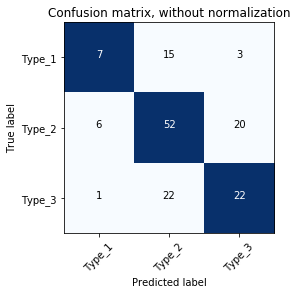

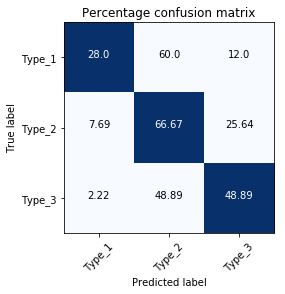

In [79]:
import plot_confusion_matrix
plot_confusion_matrix.main(expected_labels, our_labels, ['Type_1', 'Type_2', 'Type_3'])